# Setup

In [56]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [57]:
%matplotlib inline

In [58]:
from sparse_field_lib import load_data

In [59]:
import matplotlib.pyplot as plt
import sklearn
import torch

from bliss.datasets import sdss
from bliss.models import encoder, decoder
from bliss import sleep

from astropy.table import Table

In [60]:
# where is the sdss data? 
sdss_dir = '/home/imendoza/bliss/data/sdss/'

In [61]:
# check GPU is configured correctly
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

6


## Utility

In [62]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def imshow_cbar(fig, ax, image, vmin=None, vmax=None, s=20): 
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(image, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical")
    cbar.ax.tick_params(labelsize=s)

# Catalog Extraction

In [63]:
frame, fits_file, wcs_list, sdss_data = load_data(sdss_dir=sdss_dir)
frame_fits = Table(sdss_data[0]['po_fits'])
print("# objects detected by photo on frame: ", len(frame_fits))
print("# objects detected by photo on coadd: ", len(fits_file['ra'][:]))
frame = frame[0].numpy()
print(frame.shape)

# objects detected by photo on frame:  999
# objects detected by photo on coadd:  901
(1489, 2048)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '19/09/98' to '1998-09-19''. [astropy.wcs.wcs]


In [64]:
# convert to a catsim catalog
coadd_cat = Table(fits_file[:])

# keep only reasonable objects
keep = ~coadd_cat['probpsf'].astype(bool) & ~coadd_cat['is_saturated'].astype(bool) \
       & (coadd_cat['devrad_r'] < 10) & (coadd_cat['exprad_r'] < 10) # arcsec
galaxy_cat = coadd_cat[keep]

# convert to fluxes
nelec_per_nmgy = sdss_data[0]['nelec_per_nmgy'].mean()
def convert_mag_to_flux(mag):
    return 10**((22.5 - mag) / 2.5) * nelec_per_nmgy

expflux_r = convert_mag_to_flux(galaxy_cat['expmag_r'])
devflux_r = convert_mag_to_flux(galaxy_cat['devmag_r'])
galaxy_cat.add_column(expflux_r, name='expflux_r')
galaxy_cat.add_column(devflux_r, name='devflux_r')

# only want some columns also convert right format
names = ['objid', 'expflux_r', 'devflux_r','exprad_r', 'devrad_r', 'expab_r', 'devab_r', 'expphi_r', 'devphi_r']

galaxy_cat = galaxy_cat[names]

In [65]:
# galaxy_cat.write('../../data/coadd_galaxy_catalog.dat', format='ascii', overwrite=True)

# Galaxy Images

In [68]:
from bliss.datasets.galsim_galaxies import SDSSCatalogGalaxies
from bliss.models.galaxy_net import OneCenteredGalaxyAE
from omegaconf import OmegaConf

from hydra import initialize, compose

In [69]:
# load dataset and autoencoder
with initialize(config_path='../../config'):
    cfg = compose("config", overrides=['dataset=sdss_catalog_galaxies', 'model=galaxy_net'])
ds_kwargs = OmegaConf.to_container(cfg.dataset.kwargs, resolve=True)
ae_kwargs = OmegaConf.to_container(cfg)
ds = SDSSCatalogGalaxies(**ds_kwargs)
ae = OneCenteredGalaxyAE.load_from_checkpoint('../../models/sdss_autoencoder.ckpt')
ae.eval()
print(ae.training)

False


## Example images

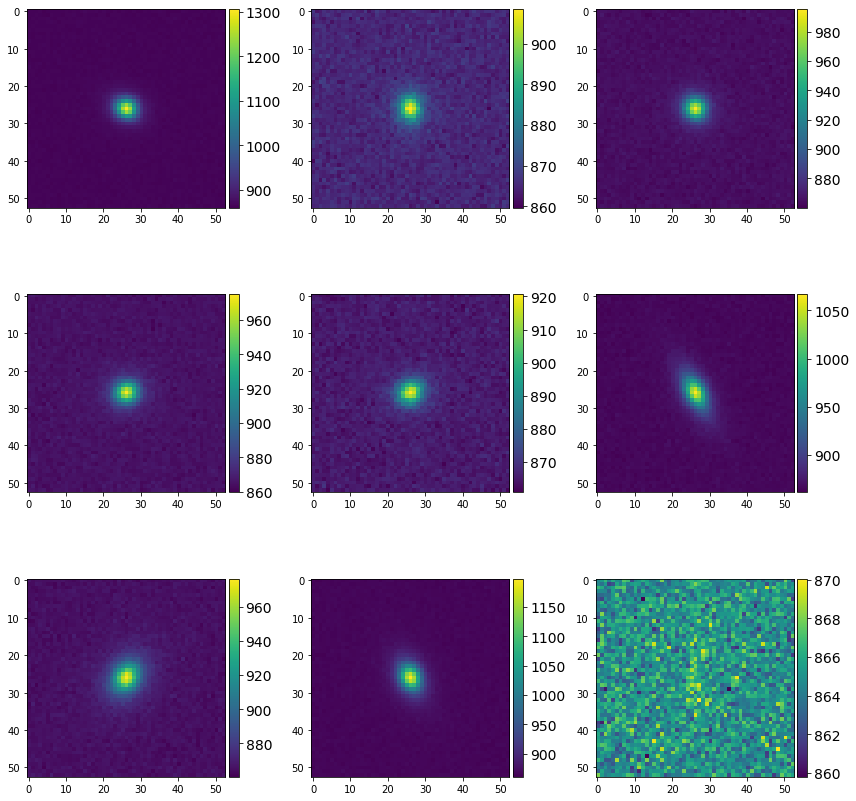

In [82]:
# example images
fig, axes = plt.subplots(3,3,figsize=(12,12))
for i in range(9):
    ax = axes.flatten()[i]
    idx = np.random.randint(0, len(ds))
    imshow_cbar(fig, ax, ds[idx]['images'].numpy()[0], s=14)
plt.tight_layout()

## Reconstructions

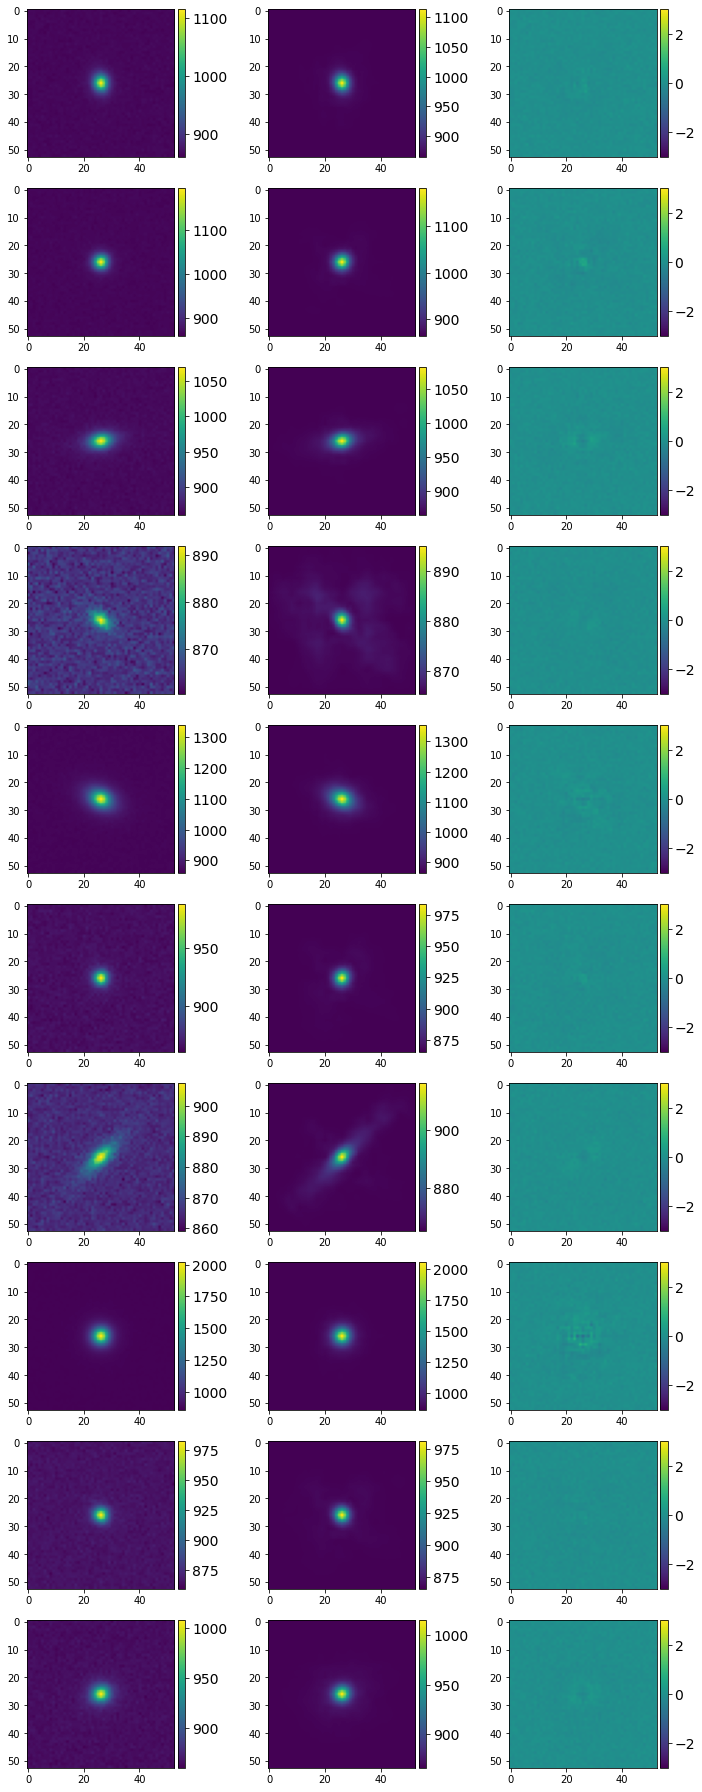

In [31]:
# example reconstructions 
fig, axes = plt.subplots(10, 3, figsize=(10, 25))
slen = 53
for i in range(10): 
    true_ax = axes[i, 0]
    recon_ax = axes[i, 1]
    res_ax = axes[i, 2]
    
    idx = np.random.randint(0, len(ds))

    # get reconstruction
    image = ds[idx]['images'].reshape(1, 1, slen, slen)
    background = ds[idx]['background'].reshape(1, 1, slen, slen)
    recon_mean = ae(image, background)
    
    # images for plotting
    image = image.numpy()[0, 0]
    recon_mean = recon_mean.detach().numpy()[0, 0]
    res = (image - recon_mean) / np.sqrt(recon_mean)
    
    imshow_cbar(fig, true_ax, image, s=14)
    imshow_cbar(fig, recon_ax, recon_mean, s=14)
    imshow_cbar(fig, res_ax, res, s=14, vmin=-3, vmax=3)
plt.tight_layout()

## Small ones look like PSF 

psf HLR: 0.7996933647498914
ratio of small galaxies: 0.4425287356321839


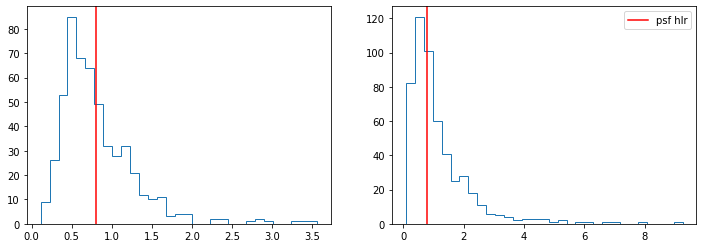

In [119]:
# clearly shows these quantities are psf-deconvolved
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
psf_hlr = ds.psf.calculateHLR()
ax1.hist(galaxy_cat['exprad_r'], histtype='step', bins=31)
ax2.hist(galaxy_cat['devrad_r'], histtype='step', bins=31)
ax1.axvline(psf_hlr, label='psf hlr', c='r')
ax2.axvline(psf_hlr, label='psf hlr', c='r')
plt.legend()
print('psf HLR:', psf_hlr)
print('ratio of small galaxies:', sum( (galaxy_cat['exprad_r'] < 0.65) | (galaxy_cat['devrad_r'] < 0.65)) / len(galaxy_cat))


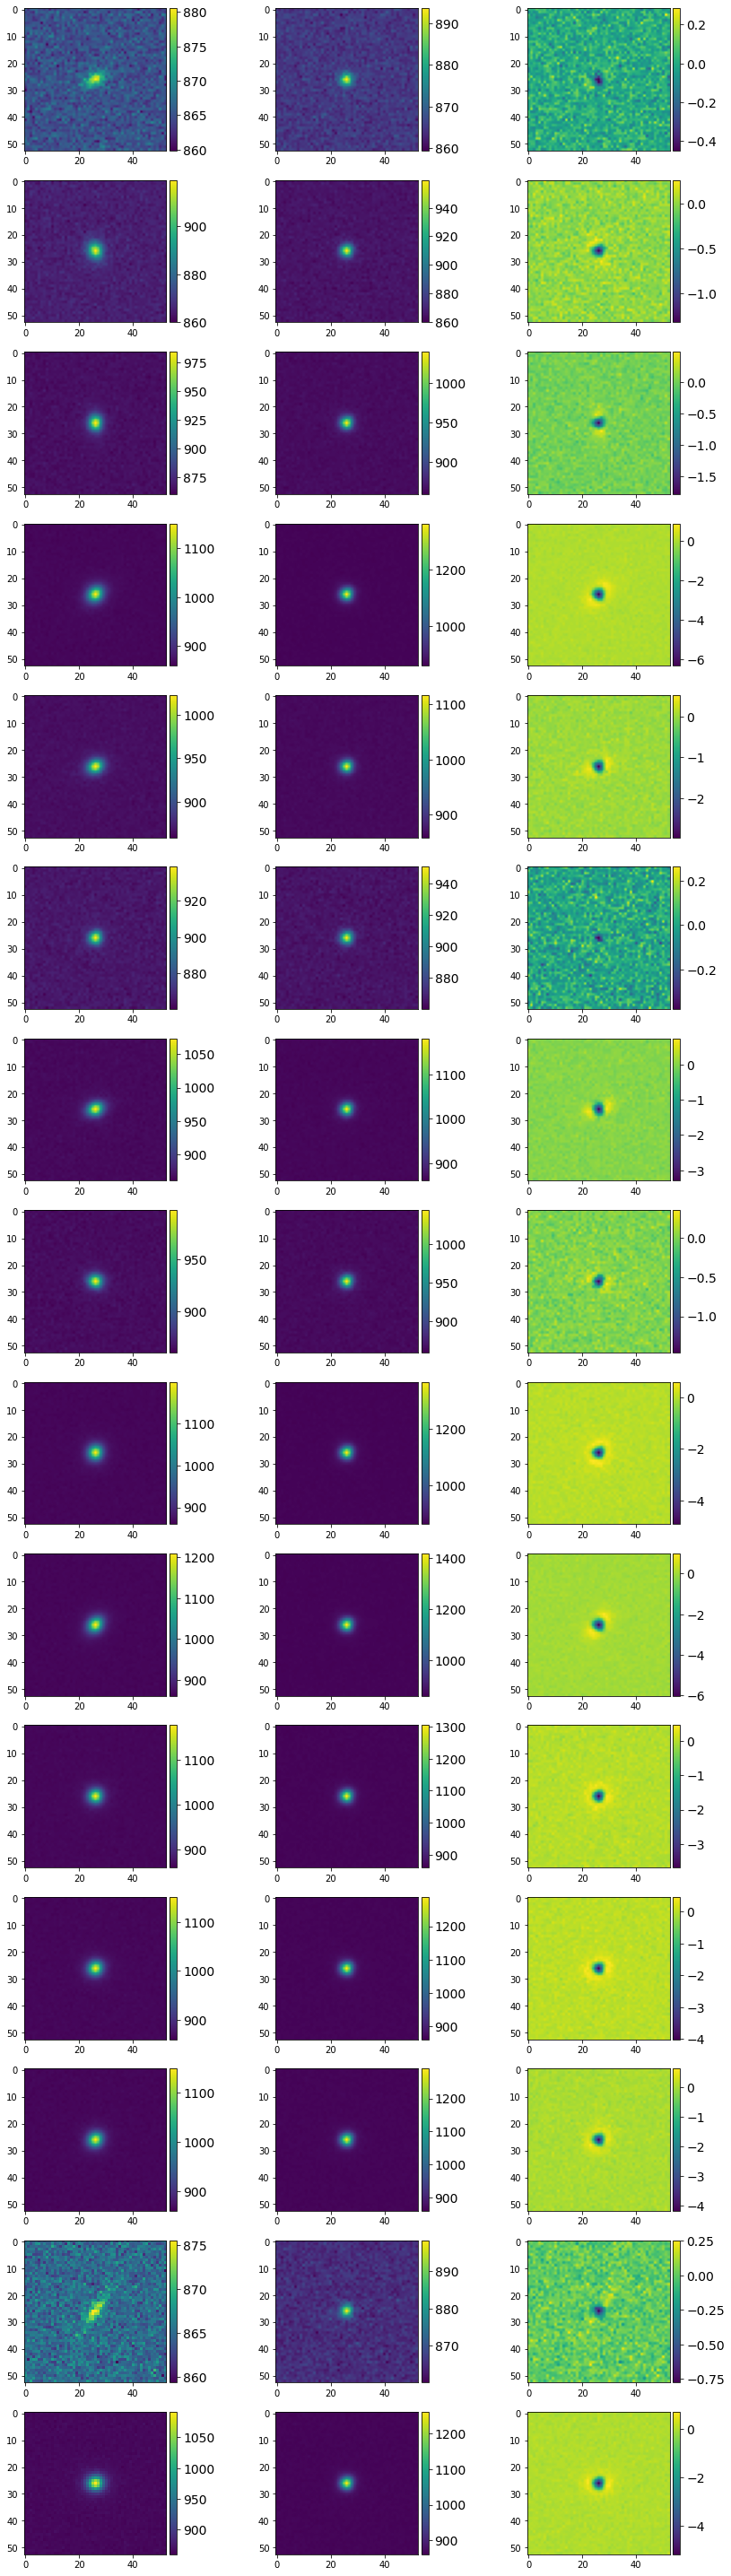

In [120]:
# small indices
indices = np.arange(len(galaxy_cat))
small_indices = indices[(galaxy_cat['exprad_r'] < 0.65) &(galaxy_cat['devrad_r'] < 0.65)]

# draw examples
fig, axes = plt.subplots(15, 3, figsize=(12, 40))
slen = 53
flux_comparison = []
for i in range(15):
    idx = np.random.choice(small_indices)
    true_ax = axes[i, 0]
    psf_ax = axes[i, 1]
    res_ax = axes[i, 2]

    # get image and background
    image = ds[idx]['images'].numpy().reshape(slen, slen)
    background = ds[idx]['background'].numpy().reshape(slen, slen)
    _flux = (image - background).sum()


    # get corresponding psf image
    flux  = galaxy_cat[idx]['expflux_r'] + galaxy_cat[idx]['devflux_r']
    psf_image = ds.psf.withFlux(flux).drawImage(nx=53, ny=53, scale=ds.pixel_scale).array
    psf_image += background
    noise = np.sqrt(psf_image) * np.random.randn(*psf_image.shape) * ds.noise_factor
    psf_image += noise
    
    flux_comparison.append((_flux, flux))
    
    # images for plotting
    res = (image - psf_image) / np.sqrt(image)
    
    imshow_cbar(fig, true_ax, image, s=14)
    imshow_cbar(fig, psf_ax, psf_image, s=14)
    imshow_cbar(fig, res_ax, res, s=14)
plt.tight_layout()

## Which ones are too dim to even detect ? 

In [96]:
max_flux = [] 
for i in range(len(galaxy_cat)):
    max_flux.append(ds[i]['images'].max().item())
max_flux = np.array(max_flux)

In [111]:
ratio = sum(max_flux < 865. + np.sqrt(865.)*3) / len(max_flux)
print(f'{ratio:.3f}')

0.397


(array([181., 143.,  60.,  28.,  35.,  21.,   6.,   7.,   9.,   5.,   9.,
          7.,   2.,   0.,   0.,   1.,   0.,   2.,   1.,   0.,   1.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([2.93945402, 2.97366518, 3.00787634, 3.0420875 , 3.07629866,
        3.11050982, 3.14472098, 3.17893214, 3.2131433 , 3.24735446,
        3.28156562, 3.31577678, 3.34998795, 3.38419911, 3.41841027,
        3.45262143, 3.48683259, 3.52104375, 3.55525491, 3.58946607,
        3.62367723, 3.65788839, 3.69209955, 3.72631071, 3.76052187,
        3.79473304, 3.8289442 , 3.86315536, 3.89736652, 3.93157768,
        3.96578884, 4.        ]),
 [<matplotlib.patches.Polygon at 0x7f3351d6a5e0>])

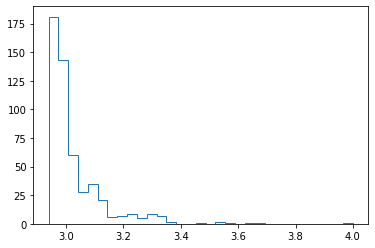

In [102]:
plt.hist(np.log10(max_flux), bins=31, histtype='step', range=(np.log10(min(max_flux)), 4))